In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

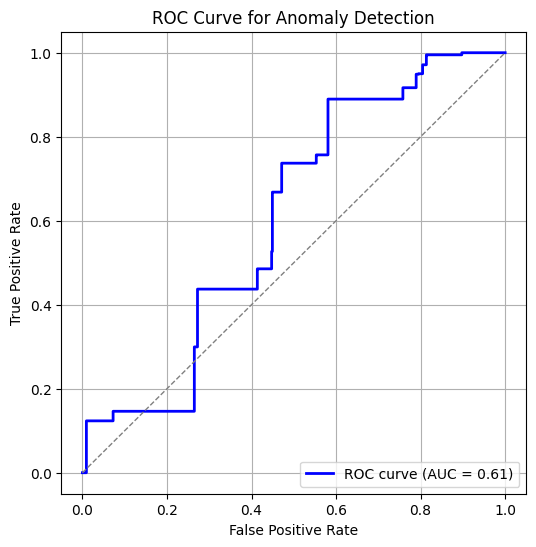

ROC-AUC Score: 0.6088149781188935


In [37]:
df = pd.read_csv("anomrank_user1_combined_or_edge_anomaly.csv")

df["atk_binary"] = (df["atk"] > 0).astype(int)
y_true = df["atk_binary"]
y_score = df["score"]
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Anomaly Detection')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
print("ROC-AUC Score:", roc_auc_score(y_true, y_score))

Timepoints: 12623 | Injections: 432


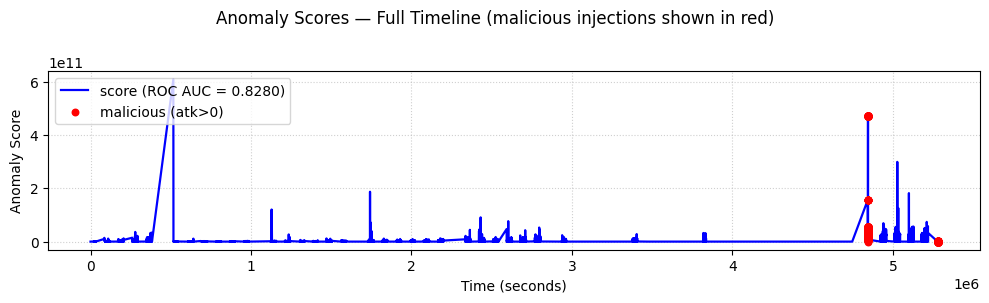

In [1]:
# full_timeline_injections_red_points_auc.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# ========= Config =========
CSV_PATH   = "anomrank_user1_combined_or_edge_anomaly.csv"
TIME_COL   = "t"        # time/index column
ATTACK_COL = "atk"      # >0 means injected/malicious
SCORE_COLS = ["score"]  # add more columns for multi-panel figure
AGG        = "max"      # per-time aggregation of scores: "max" | "mean" | "sum"
TIME_UNIT  = "seconds"  # unit label for the x-axis

# ========= Load & preprocess =========
df = pd.read_csv(CSV_PATH)

# basic checks
missing = {TIME_COL, ATTACK_COL}.difference(df.columns)
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}")
for c in SCORE_COLS:
    if c not in df.columns:
        raise ValueError(f"Missing score column '{c}'. Available: {list(df.columns)}")

# numeric coercion
df[TIME_COL]   = pd.to_numeric(df[TIME_COL], errors="coerce")
df[ATTACK_COL] = pd.to_numeric(df[ATTACK_COL], errors="coerce")
for c in SCORE_COLS:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=[TIME_COL, ATTACK_COL] + SCORE_COLS)
df["atk_binary"] = (df[ATTACK_COL] > 0).astype(int)

# ========= Aggregate per time =========
if AGG not in {"max", "mean", "sum"}:
    raise ValueError("AGG must be one of {'max','mean','sum'}")

score_agg = df.groupby(TIME_COL)[SCORE_COLS].agg(AGG)
attack_by_t = df.groupby(TIME_COL)["atk_binary"].max()
g = score_agg.join(attack_by_t, how="left").fillna({"atk_binary": 0})

times = g.index.to_numpy()
inject_times = times[g["atk_binary"].astype(bool).to_numpy()]
inject_times = np.unique(inject_times)

print(f"Timepoints: {len(times)} | Injections: {len(inject_times)}")
if len(inject_times) == 0:
    print("No injections (atk>0) found.")

# ========= Plot (full timeline only, red dots + ROC-AUC) =========
n = len(SCORE_COLS)
fig, axes = plt.subplots(n, 1, figsize=(10, 3 * n), sharex=True)
if n == 1:
    axes = [axes]

for ax, col in zip(axes, SCORE_COLS):
    y = g[col].to_numpy()

    # compute ROC-AUC for this column
    y_true = g["atk_binary"].to_numpy()
    try:
        auc_value = roc_auc_score(y_true, y)
        auc_label = f" (ROC AUC = {auc_value:.4f})"
    except ValueError:
        auc_label = " (ROC AUC unavailable)"
        auc_value = np.nan

    ax.plot(times, y, linewidth=1.6, label=f"{col}{auc_label}", color='blue')

    # red dots for injected (malicious) points
    if len(inject_times) > 0:
        y_inj = g.loc[inject_times, col].to_numpy()
        ax.scatter(inject_times, y_inj, s=22, color='red', marker='o',
                   label="malicious (atk>0)", zorder=5)

    ax.set_ylabel("Anomaly Score")
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.legend(loc="upper left")

axes[-1].set_xlabel(f"Time ({TIME_UNIT})")

fig.suptitle("Anomaly Scores — Full Timeline (malicious injections shown in red)", y=0.995)
fig.tight_layout()
plt.show()


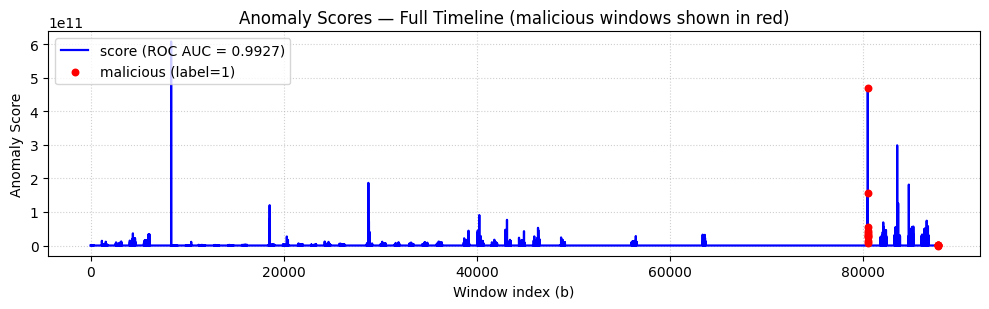

In [2]:
# full_timeline_from_scores_txt_auc.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# ===== Config =====
PATH = "anomrank_user1_combined_or_anomaly.txt"   
HAS_HEADER = False                    
SCORE_COL_NAME = "score"
LABEL_COL_NAME = "label"
X_LABEL = "Window index (b)"         

# ===== Load (robust to spaces/tabs; no header expected) =====
if HAS_HEADER:
    df = pd.read_csv(PATH, sep=r"\s+")
    # make sure columns exist
    if not {SCORE_COL_NAME, LABEL_COL_NAME}.issubset(df.columns):
        raise ValueError(f"Expected columns '{SCORE_COL_NAME}' and '{LABEL_COL_NAME}' in {PATH}")
    df = df[[SCORE_COL_NAME, LABEL_COL_NAME]].copy()
else:
    df = pd.read_csv(PATH, sep=r"\s+", header=None, names=[SCORE_COL_NAME, LABEL_COL_NAME])

# Coerce numerics & drop bad rows
df[SCORE_COL_NAME] = pd.to_numeric(df[SCORE_COL_NAME], errors="coerce")
df[LABEL_COL_NAME] = pd.to_numeric(df[LABEL_COL_NAME], errors="coerce").astype("Int64")
df = df.dropna(subset=[SCORE_COL_NAME, LABEL_COL_NAME]).reset_index(drop=True)

# Build arrays
y_score = df[SCORE_COL_NAME].to_numpy()
y_true  = df[LABEL_COL_NAME].astype(int).to_numpy()
x = np.arange(len(df))  # window index

# ROC AUC (handle degenerate cases gracefully)
try:
    auc_value = roc_auc_score(y_true, y_score)
    auc_text = f"(ROC AUC = {auc_value:.4f})"
except ValueError:
    auc_value = np.nan
    auc_text = "(ROC AUC unavailable)"

# ===== Plot =====
plt.figure(figsize=(10, 3.2))
plt.plot(x, y_score, linewidth=1.6, color="blue", label=f"score {auc_text}")

# Red dots where label == 1
mal_idx = np.where(y_true == 1)[0]
if mal_idx.size > 0:
    plt.scatter(mal_idx, y_score[mal_idx], s=22, color="red", marker="o",
                label="malicious (label=1)", zorder=5)

plt.xlabel(X_LABEL)
plt.ylabel("Anomaly Score")
plt.title("Anomaly Scores — Full Timeline (malicious windows shown in red)")
plt.grid(True, linestyle=":", alpha=0.6)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()


In [ ]:
# ===== Snapshots: contiguous runs of the same anomaly score =====
import numpy as np
import pandas as pd

def compute_snapshots(times: np.ndarray,
                      values: np.ndarray,
                      eps: float | None = None,
                      round_decimals: int | None = None) -> pd.DataFrame:
    v = values.copy()

    if round_decimals is not None:
        v = np.round(v, round_decimals)

    def same(a, b):
        if eps is None:
            return a == b
        return np.abs(a - b) <= eps

    snaps = []
    start_idx = 0
    for i in range(1, len(v)):
        if not same(v[i], v[i - 1]):
            snaps.append({
                "start_time": times[start_idx],
                "end_time": times[i - 1],
                "length": i - start_idx,
                "score": v[start_idx]
            })
            start_idx = i
    # close last run
    snaps.append({
        "start_time": times[start_idx],
        "end_time": times[len(v) - 1],
        "length": len(v) - start_idx,
        "score": v[start_idx]
    })
    return pd.DataFrame(snaps)

# === Choose one score column to analyze (or loop over SCORE_COLS)
score_col = SCORE_COLS[0]

# If your scores are raw floats, rounding usually produces cleaner grouping.
# Adjust round_decimals/eps to taste: e.g., round_decimals=6 or eps=1e-9
snap_df = compute_snapshots(
    times=times,
    values=g[score_col].to_numpy(),
    round_decimals=6,   # set None if you prefer exact equality
    eps=None            # or use eps=1e-12 without rounding
)

print(f"[{score_col}] Total snapshots (contiguous runs of same score): {len(snap_df)}")
print(snap_df.head(10))  # preview

# === If you also want 'malicious-only snapshots' (runs that overlap any atk>0 time)
atk_times_set = set(inject_times.tolist())
def overlaps_attack(row):
    # any time in [start_time, end_time] that is an injection time?
    # since times are unique and sorted, we can check membership quickly
    # for dense data you might speed this using a search; this is fine typically
    return any((t in atk_times_set) for t in times[(times >= row.start_time) & (times <= row.end_time)])

snap_df["overlaps_attack"] = snap_df.apply(overlaps_attack, axis=1)
mal_snap_df = snap_df[snap_df["overlaps_attack"]].copy()

print(f"[{score_col}] Snapshots overlapping attacks: {len(mal_snap_df)}")
# Optional summaries:
print("Top snapshots by length:")
print(snap_df.sort_values("length", ascending=False).head(10)[["start_time","end_time","length","score"]])


[score] Total snapshots (contiguous runs of same score): 2951
   start_time  end_time  length         score
0           1     13449      66  0.000000e+00
1       17484     17485       2  1.405705e+07
2       17542     17542       1  1.223267e+07
3       19181     19316       3  0.000000e+00
4       19461     19461       1  8.958804e+08
5       19981     19981       1  4.205082e+08
6       20771     20818       4  3.782208e+06
7       21365     22661       2  0.000000e+00
8       22703     22703       1  4.938453e+08
9       22755     22755       1  7.741353e+08


[score] Snapshots overlapping attacks: 16
Top snapshots by length:
      start_time  end_time  length         score
0              1     13449      66  0.000000e+00
2440     4845361   4845420      60  5.485755e+10
2441     4845421   4845480      60  2.943625e+10
2439     4845301   4845360      60  4.425450e+10
810      1129921   1129980      60  7.548900e+10
1220     1750621   1750679      58  3.994880e+10
799      1128481   1128540      58  1.202695e+11
2442     4845481   4845537      57  7.637179e+09
2821     5122741   5123074      57  0.000000e+00
2438     4845241   4845300      54  4.701216e+11


In [40]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score


print("score stats:", df["score"].min(), df["score"].max())
print("unique scores:", df["score"].nunique(), " | positives:", y_true.sum(), " | negatives:", len(y_true)-y_true.sum())
print("proportion with score > 0:", (df["score"] > 0).mean())


youden = tpr - fpr
best_idx_j = np.argmax(youden)
best_thr_j  = thresholds[best_idx_j]
print(f"[Youden J] best threshold={best_thr_j:.6g}, TPR={tpr[best_idx_j]:.3f}, FPR={fpr[best_idx_j]:.3f}")


dist = (fpr**2 + (1 - tpr)**2)
best_idx_tl = np.argmin(dist)
best_thr_tl = thresholds[best_idx_tl]
print(f"[Top-Left] best threshold={best_thr_tl:.6g}, TPR={tpr[best_idx_tl]:.3f}, FPR={fpr[best_idx_tl]:.3f}")

# F1-optimal threshold via PR curve
prec, rec, thr_pr = precision_recall_curve(y_true, y_score)
# precision_recall_curve returns thresholds aligned with thr_pr; last point has no threshold
f1s = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-12)
best_idx_f1 = np.argmax(f1s)
best_thr_f1 = thr_pr[best_idx_f1]
print(f"[Max F1]   best threshold={best_thr_f1:.6g}, Precision={prec[best_idx_f1]:.3f}, Recall={rec[best_idx_f1]:.3f}, F1={f1s[best_idx_f1]:.3f}")

# manual cutoff
manual_thr = 0.5
# Compute metrics 
y_pred_manual = (y_score > manual_thr).astype(int)
from sklearn.metrics import confusion_matrix, classification_report
tn, fp, fn, tp = confusion_matrix(y_true, y_pred_manual).ravel()
tpr_manual = tp / (tp + fn) if (tp + fn) else 0.0
fpr_manual = fp / (fp + tn) if (fp + tn) else 0.0
print(f"[Manual score] TPR={tpr_manual:.3f}, FPR={fpr_manual:.3f}")
print(classification_report(y_true, y_pred_manual, digits=3))


score stats: 0.0 608415820056.085
unique scores: 2415  | positives: 21662  | negatives: 274051
proportion with score > 0: 0.9206933749953502
[Youden J] best threshold=7.63718e+09, TPR=0.890, FPR=0.581
[Top-Left] best threshold=2.50883e+10, TPR=0.737, FPR=0.471
[Max F1]   best threshold=4.70122e+11, Precision=0.509, Recall=0.123, F1=0.199
[Manual score] TPR=1.000, FPR=0.914
              precision    recall  f1-score   support

           0      1.000     0.086     0.158    274051
           1      0.080     1.000     0.147     21662

    accuracy                          0.153    295713
   macro avg      0.540     0.543     0.153    295713
weighted avg      0.933     0.153     0.157    295713



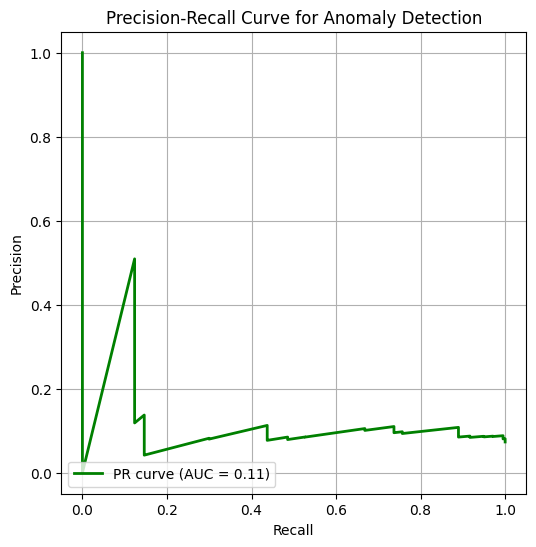

PR-AUC Score (trapz-based): 0.109855
Average Precision (sklearn): 0.150023


In [41]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score


prec, rec, _ = precision_recall_curve(y_true, y_score)

# PR-AUC 
pr_auc = auc(rec, prec)
avg_prec = average_precision_score(y_true, y_score)


plt.figure(figsize=(6,6))
plt.plot(rec, prec, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Anomaly Detection')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


print(f"PR-AUC Score (trapz-based): {pr_auc:.6f}")
print(f"Average Precision (sklearn): {avg_prec:.6f}")


In [43]:
# ===== Snapshots: contiguous runs of the same anomaly score =====
import numpy as np
import pandas as pd

def compute_snapshots(times: np.ndarray,
                      values: np.ndarray,
                      eps: float | None = None,
                      round_decimals: int | None = None) -> pd.DataFrame:
    v = values.copy()

    if round_decimals is not None:
        v = np.round(v, round_decimals)

    def same(a, b):
        if eps is None:
            return a == b
        return np.abs(a - b) <= eps

    snaps = []
    start_idx = 0
    for i in range(1, len(v)):
        if not same(v[i], v[i - 1]):
            snaps.append({
                "start_time": times[start_idx],
                "end_time": times[i - 1],
                "length": i - start_idx,
                "score": v[start_idx]
            })
            start_idx = i
    # close last run
    snaps.append({
        "start_time": times[start_idx],
        "end_time": times[len(v) - 1],
        "length": len(v) - start_idx,
        "score": v[start_idx]
    })
    return pd.DataFrame(snaps)

# === Choose one score column to analyze (or loop over SCORE_COLS)
score_col = SCORE_COLS[0]

# If your scores are raw floats, rounding usually produces cleaner grouping.
# Adjust round_decimals/eps to taste: e.g., round_decimals=6 or eps=1e-9
snap_df = compute_snapshots(
    times=times,
    values=g[score_col].to_numpy(),
    round_decimals=6,   # set None if you prefer exact equality
    eps=None            # or use eps=1e-12 without rounding
)

print(f"[{score_col}] Total snapshots (contiguous runs of same score): {len(snap_df)}")
print(snap_df.head(10))  # preview

atk_times_set = set(inject_times.tolist())
def overlaps_attack(row):

    return any((t in atk_times_set) for t in times[(times >= row.start_time) & (times <= row.end_time)])

snap_df["overlaps_attack"] = snap_df.apply(overlaps_attack, axis=1)
mal_snap_df = snap_df[snap_df["overlaps_attack"]].copy()

print(f"[{score_col}] Snapshots overlapping attacks: {len(mal_snap_df)}")
# Optional summaries:
print("Top snapshots by length:")
print(snap_df.sort_values("length", ascending=False).head(10)[["start_time","end_time","length","score"]])


[score] Total snapshots (contiguous runs of same score): 2951
   start_time  end_time  length         score
0           1     13449      66  0.000000e+00
1       17484     17485       2  1.405705e+07
2       17542     17542       1  1.223267e+07
3       19181     19316       3  0.000000e+00
4       19461     19461       1  8.958804e+08
5       19981     19981       1  4.205082e+08
6       20771     20818       4  3.782208e+06
7       21365     22661       2  0.000000e+00
8       22703     22703       1  4.938453e+08
9       22755     22755       1  7.741353e+08
[score] Snapshots overlapping attacks: 16
Top snapshots by length:
      start_time  end_time  length         score
0              1     13449      66  0.000000e+00
2440     4845361   4845420      60  5.485755e+10
2441     4845421   4845480      60  2.943625e+10
2439     4845301   4845360      60  4.425450e+10
810      1129921   1129980      60  7.548900e+10
1220     1750621   1750679      58  3.994880e+10
799      1128481   112

User7

Timepoints: 14068 | Injections: 542


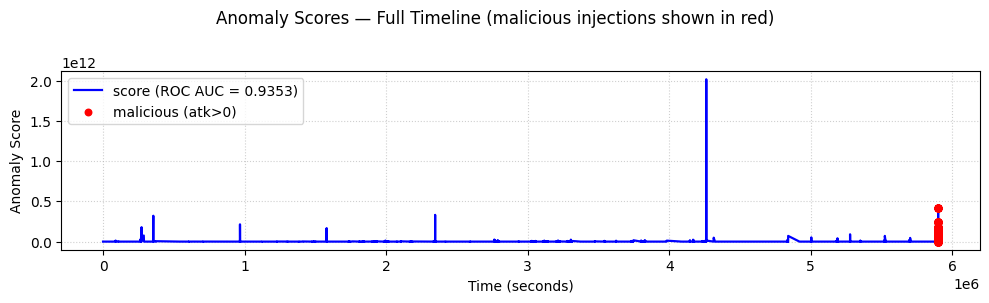

In [3]:
# full_timeline_injections_red_points_auc.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# ========= Config =========
CSV_PATH   = "anomrank_user7_combined_or_edge_anomaly.csv"
TIME_COL   = "t"        # time/index column
ATTACK_COL = "atk"      # >0 means injected/malicious
SCORE_COLS = ["score"]  # add more columns for multi-panel figure
AGG        = "max"      # per-time aggregation of scores: "max" | "mean" | "sum"
TIME_UNIT  = "seconds"  # unit label for the x-axis

# ========= Load & preprocess =========
df = pd.read_csv(CSV_PATH)

# basic checks
missing = {TIME_COL, ATTACK_COL}.difference(df.columns)
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}")
for c in SCORE_COLS:
    if c not in df.columns:
        raise ValueError(f"Missing score column '{c}'. Available: {list(df.columns)}")

# numeric coercion
df[TIME_COL]   = pd.to_numeric(df[TIME_COL], errors="coerce")
df[ATTACK_COL] = pd.to_numeric(df[ATTACK_COL], errors="coerce")
for c in SCORE_COLS:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=[TIME_COL, ATTACK_COL] + SCORE_COLS)
df["atk_binary"] = (df[ATTACK_COL] > 0).astype(int)

# ========= Aggregate per time =========
if AGG not in {"max", "mean", "sum"}:
    raise ValueError("AGG must be one of {'max','mean','sum'}")

score_agg = df.groupby(TIME_COL)[SCORE_COLS].agg(AGG)
attack_by_t = df.groupby(TIME_COL)["atk_binary"].max()
g = score_agg.join(attack_by_t, how="left").fillna({"atk_binary": 0})

times = g.index.to_numpy()
inject_times = times[g["atk_binary"].astype(bool).to_numpy()]
inject_times = np.unique(inject_times)

print(f"Timepoints: {len(times)} | Injections: {len(inject_times)}")
if len(inject_times) == 0:
    print("No injections (atk>0) found.")

# ========= Plot (full timeline only, red dots + ROC-AUC) =========
n = len(SCORE_COLS)
fig, axes = plt.subplots(n, 1, figsize=(10, 3 * n), sharex=True)
if n == 1:
    axes = [axes]

for ax, col in zip(axes, SCORE_COLS):
    y = g[col].to_numpy()

    # compute ROC-AUC for this column
    y_true = g["atk_binary"].to_numpy()
    try:
        auc_value = roc_auc_score(y_true, y)
        auc_label = f" (ROC AUC = {auc_value:.4f})"
    except ValueError:
        auc_label = " (ROC AUC unavailable)"
        auc_value = np.nan

    ax.plot(times, y, linewidth=1.6, label=f"{col}{auc_label}", color='blue')

    # red dots for injected (malicious) points
    if len(inject_times) > 0:
        y_inj = g.loc[inject_times, col].to_numpy()
        ax.scatter(inject_times, y_inj, s=22, color='red', marker='o',
                   label="malicious (atk>0)", zorder=5)

    ax.set_ylabel("Anomaly Score")
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.legend(loc="upper left")

axes[-1].set_xlabel(f"Time ({TIME_UNIT})")

fig.suptitle("Anomaly Scores — Full Timeline (malicious injections shown in red)", y=0.995)
fig.tight_layout()
plt.show()


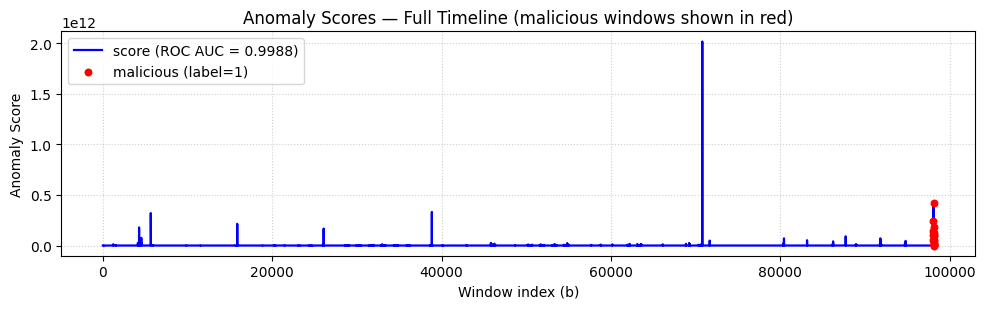

In [4]:
# full_timeline_from_scores_txt_auc.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# ===== Config =====
PATH = "anomrank_user7_combined_or_anomaly.txt"   
HAS_HEADER = False                    
SCORE_COL_NAME = "score"
LABEL_COL_NAME = "label"
X_LABEL = "Window index (b)"         

# ===== Load (robust to spaces/tabs; no header expected) =====
if HAS_HEADER:
    df = pd.read_csv(PATH, sep=r"\s+")
    # make sure columns exist
    if not {SCORE_COL_NAME, LABEL_COL_NAME}.issubset(df.columns):
        raise ValueError(f"Expected columns '{SCORE_COL_NAME}' and '{LABEL_COL_NAME}' in {PATH}")
    df = df[[SCORE_COL_NAME, LABEL_COL_NAME]].copy()
else:
    df = pd.read_csv(PATH, sep=r"\s+", header=None, names=[SCORE_COL_NAME, LABEL_COL_NAME])

# Coerce numerics & drop bad rows
df[SCORE_COL_NAME] = pd.to_numeric(df[SCORE_COL_NAME], errors="coerce")
df[LABEL_COL_NAME] = pd.to_numeric(df[LABEL_COL_NAME], errors="coerce").astype("Int64")
df = df.dropna(subset=[SCORE_COL_NAME, LABEL_COL_NAME]).reset_index(drop=True)

# Build arrays
y_score = df[SCORE_COL_NAME].to_numpy()
y_true  = df[LABEL_COL_NAME].astype(int).to_numpy()
x = np.arange(len(df))  # window index

# ROC AUC (handle degenerate cases gracefully)
try:
    auc_value = roc_auc_score(y_true, y_score)
    auc_text = f"(ROC AUC = {auc_value:.4f})"
except ValueError:
    auc_value = np.nan
    auc_text = "(ROC AUC unavailable)"

# ===== Plot =====
plt.figure(figsize=(10, 3.2))
plt.plot(x, y_score, linewidth=1.6, color="blue", label=f"score {auc_text}")

# Red dots where label == 1
mal_idx = np.where(y_true == 1)[0]
if mal_idx.size > 0:
    plt.scatter(mal_idx, y_score[mal_idx], s=22, color="red", marker="o",
                label="malicious (label=1)", zorder=5)

plt.xlabel(X_LABEL)
plt.ylabel("Anomaly Score")
plt.title("Anomaly Scores — Full Timeline (malicious windows shown in red)")
plt.grid(True, linestyle=":", alpha=0.6)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()


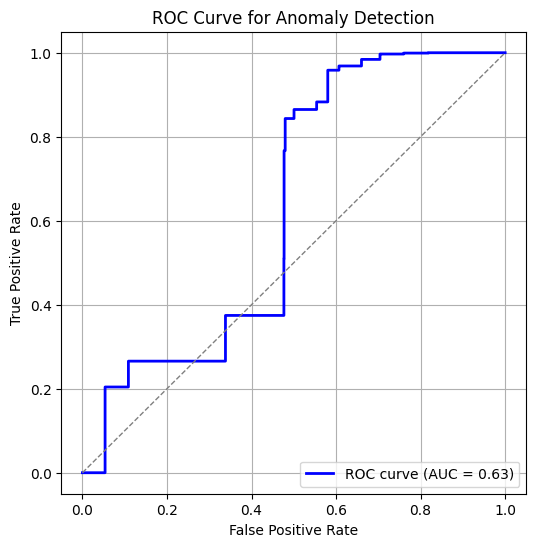

ROC-AUC Score: 0.6292755867834787


In [45]:
df = pd.read_csv("anomrank_user7_combined_or_edge_anomaly.csv")
df["atk_binary"] = (df["atk"] > 0).astype(int)
y_true = df["atk_binary"]
y_score = df["score"]
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Anomaly Detection')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
print("ROC-AUC Score:", roc_auc_score(y_true, y_score))

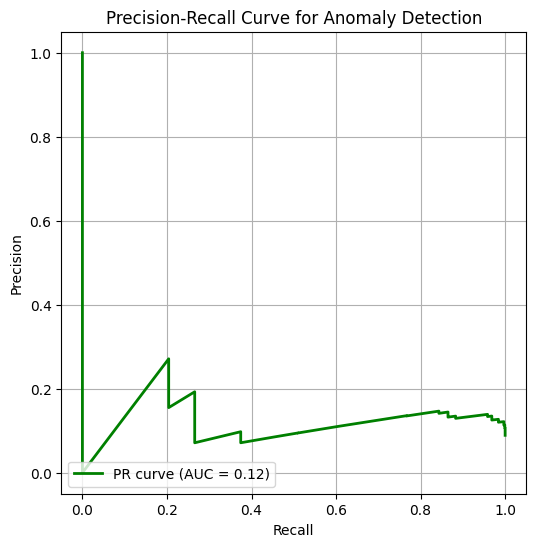

PR-AUC Score (trapz-based): 0.120102
Average Precision (sklearn): 0.154617


In [46]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score


prec, rec, _ = precision_recall_curve(y_true, y_score)

# PR-AUC 
pr_auc = auc(rec, prec)
avg_prec = average_precision_score(y_true, y_score)


plt.figure(figsize=(6,6))
plt.plot(rec, prec, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Anomaly Detection')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


print(f"PR-AUC Score (trapz-based): {pr_auc:.6f}")
print(f"Average Precision (sklearn): {avg_prec:.6f}")


In [47]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score


print("score stats:", df["score"].min(), df["score"].max())
print("unique scores:", df["score"].nunique(), " | positives:", y_true.sum(), " | negatives:", len(y_true)-y_true.sum())
print("proportion with score > 0:", (df["score"] > 0).mean())


youden = tpr - fpr
best_idx_j = np.argmax(youden)
best_thr_j  = thresholds[best_idx_j]
print(f"[Youden J] best threshold={best_thr_j:.6g}, TPR={tpr[best_idx_j]:.3f}, FPR={fpr[best_idx_j]:.3f}")


dist = (fpr**2 + (1 - tpr)**2)
best_idx_tl = np.argmin(dist)
best_thr_tl = thresholds[best_idx_tl]
print(f"[Top-Left] best threshold={best_thr_tl:.6g}, TPR={tpr[best_idx_tl]:.3f}, FPR={fpr[best_idx_tl]:.3f}")

# F1-optimal threshold via PR curve
prec, rec, thr_pr = precision_recall_curve(y_true, y_score)
# precision_recall_curve returns thresholds aligned with thr_pr; last point has no threshold
f1s = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-12)
best_idx_f1 = np.argmax(f1s)
best_thr_f1 = thr_pr[best_idx_f1]
print(f"[Max F1]   best threshold={best_thr_f1:.6g}, Precision={prec[best_idx_f1]:.3f}, Recall={rec[best_idx_f1]:.3f}, F1={f1s[best_idx_f1]:.3f}")

# manual cutoff
manual_thr = 0.5
# Compute metrics 
y_pred_manual = (y_score > manual_thr).astype(int)
from sklearn.metrics import confusion_matrix, classification_report
tn, fp, fn, tp = confusion_matrix(y_true, y_pred_manual).ravel()
tpr_manual = tp / (tp + fn) if (tp + fn) else 0.0
fpr_manual = fp / (fp + tn) if (fp + tn) else 0.0
print(f"[Manual score>0] TPR={tpr_manual:.3f}, FPR={fpr_manual:.3f}")
print(classification_report(y_true, y_pred_manual, digits=3))


score stats: 0.0 2015982825544.836
unique scores: 1589  | positives: 33340  | negatives: 341029
proportion with score > 0: 0.83694429827256
[Youden J] best threshold=1.5832e+10, TPR=0.958, FPR=0.580
[Top-Left] best threshold=5.37777e+10, TPR=0.843, FPR=0.480
[Max F1]   best threshold=5.37777e+10, Precision=0.147, Recall=0.843, F1=0.250
[Manual score>0] TPR=1.000, FPR=0.821
              precision    recall  f1-score   support

           0      1.000     0.179     0.304    341029
           1      0.106     1.000     0.192     33340

    accuracy                          0.252    374369
   macro avg      0.553     0.589     0.248    374369
weighted avg      0.920     0.252     0.294    374369



In [48]:
# ===== Snapshots: contiguous runs of the same anomaly score =====
import numpy as np
import pandas as pd

def compute_snapshots(times: np.ndarray,
                      values: np.ndarray,
                      eps: float | None = None,
                      round_decimals: int | None = None) -> pd.DataFrame:
    v = values.copy()

    if round_decimals is not None:
        v = np.round(v, round_decimals)

    def same(a, b):
        if eps is None:
            return a == b
        return np.abs(a - b) <= eps

    snaps = []
    start_idx = 0
    for i in range(1, len(v)):
        if not same(v[i], v[i - 1]):
            snaps.append({
                "start_time": times[start_idx],
                "end_time": times[i - 1],
                "length": i - start_idx,
                "score": v[start_idx]
            })
            start_idx = i
    # close last run
    snaps.append({
        "start_time": times[start_idx],
        "end_time": times[len(v) - 1],
        "length": len(v) - start_idx,
        "score": v[start_idx]
    })
    return pd.DataFrame(snaps)

# === Choose one score column to analyze (or loop over SCORE_COLS)
score_col = SCORE_COLS[0]

# If your scores are raw floats, rounding usually produces cleaner grouping.
# Adjust round_decimals/eps to taste: e.g., round_decimals=6 or eps=1e-9
snap_df = compute_snapshots(
    times=times,
    values=g[score_col].to_numpy(),
    round_decimals=6,   # set None if you prefer exact equality
    eps=None            # or use eps=1e-12 without rounding
)

print(f"[{score_col}] Total snapshots (contiguous runs of same score): {len(snap_df)}")
print(snap_df.head(10))  # preview

atk_times_set = set(inject_times.tolist())
def overlaps_attack(row):

    return any((t in atk_times_set) for t in times[(times >= row.start_time) & (times <= row.end_time)])

snap_df["overlaps_attack"] = snap_df.apply(overlaps_attack, axis=1)
mal_snap_df = snap_df[snap_df["overlaps_attack"]].copy()

print(f"[{score_col}] Snapshots overlapping attacks: {len(mal_snap_df)}")
# Optional summaries:
print("Top snapshots by length:")
print(snap_df.sort_values("length", ascending=False).head(10)[["start_time","end_time","length","score"]])


[score] Total snapshots (contiguous runs of same score): 2186
   start_time  end_time  length         score
0           1      9990      67  0.000000e+00
1       23233     23239       5  1.379522e+09
2       23363     23375       9  1.156937e+09
3       25722     25740       4  8.157397e+08
4       25778     25793       7  3.945749e+08
5       25936     25946       5  7.274289e+08
6       30043     30043       1  0.000000e+00
7       87274     87297      11  2.356814e+07
8       87302     87344       7  7.030889e+06
9       87465     87769      13  0.000000e+00
[score] Snapshots overlapping attacks: 18
Top snapshots by length:
      start_time  end_time  length         score
548       985037   1120185     142  0.000000e+00
31        289214    353474     137  0.000000e+00
457       910689    946137     102  0.000000e+00
1588     2788030   2788976      87  0.000000e+00
1123     1833088   1838391      84  0.000000e+00
2045     4174256   4233834      78  0.000000e+00
1529     2676756   276

User 12

Timepoints: 15346 | Injections: 369


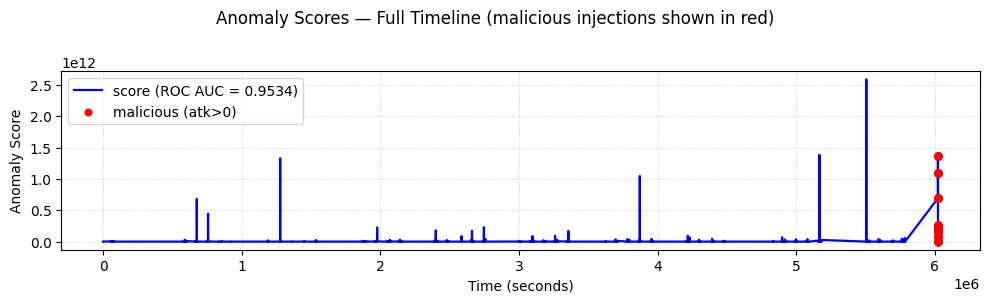

In [5]:
# full_timeline_injections_red_points_auc.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# ========= Config =========
CSV_PATH   = "anomrank_user12_combined_or_edge_anomaly.csv"
TIME_COL   = "t"        # time/index column
ATTACK_COL = "atk"      # >0 means injected/malicious
SCORE_COLS = ["score"]  # add more columns for multi-panel figure
AGG        = "max"      # per-time aggregation of scores: "max" | "mean" | "sum"
TIME_UNIT  = "seconds"  # unit label for the x-axis

# ========= Load & preprocess =========
df = pd.read_csv(CSV_PATH)

# basic checks
missing = {TIME_COL, ATTACK_COL}.difference(df.columns)
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}")
for c in SCORE_COLS:
    if c not in df.columns:
        raise ValueError(f"Missing score column '{c}'. Available: {list(df.columns)}")

# numeric coercion
df[TIME_COL]   = pd.to_numeric(df[TIME_COL], errors="coerce")
df[ATTACK_COL] = pd.to_numeric(df[ATTACK_COL], errors="coerce")
for c in SCORE_COLS:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=[TIME_COL, ATTACK_COL] + SCORE_COLS)
df["atk_binary"] = (df[ATTACK_COL] > 0).astype(int)

# ========= Aggregate per time =========
if AGG not in {"max", "mean", "sum"}:
    raise ValueError("AGG must be one of {'max','mean','sum'}")

score_agg = df.groupby(TIME_COL)[SCORE_COLS].agg(AGG)
attack_by_t = df.groupby(TIME_COL)["atk_binary"].max()
g = score_agg.join(attack_by_t, how="left").fillna({"atk_binary": 0})

times = g.index.to_numpy()
inject_times = times[g["atk_binary"].astype(bool).to_numpy()]
inject_times = np.unique(inject_times)

print(f"Timepoints: {len(times)} | Injections: {len(inject_times)}")
if len(inject_times) == 0:
    print("No injections (atk>0) found.")

# ========= Plot (full timeline only, red dots + ROC-AUC) =========
n = len(SCORE_COLS)
fig, axes = plt.subplots(n, 1, figsize=(10, 3 * n), sharex=True)
if n == 1:
    axes = [axes]

for ax, col in zip(axes, SCORE_COLS):
    y = g[col].to_numpy()

    # compute ROC-AUC for this column
    y_true = g["atk_binary"].to_numpy()
    try:
        auc_value = roc_auc_score(y_true, y)
        auc_label = f" (ROC AUC = {auc_value:.4f})"
    except ValueError:
        auc_label = " (ROC AUC unavailable)"
        auc_value = np.nan

    ax.plot(times, y, linewidth=1.6, label=f"{col}{auc_label}", color='blue')

    # red dots for injected (malicious) points
    if len(inject_times) > 0:
        y_inj = g.loc[inject_times, col].to_numpy()
        ax.scatter(inject_times, y_inj, s=22, color='red', marker='o',
                   label="malicious (atk>0)", zorder=5)

    ax.set_ylabel("Anomaly Score")
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.legend(loc="upper left")

axes[-1].set_xlabel(f"Time ({TIME_UNIT})")

fig.suptitle("Anomaly Scores — Full Timeline (malicious injections shown in red)", y=0.995)
fig.tight_layout()
plt.show()


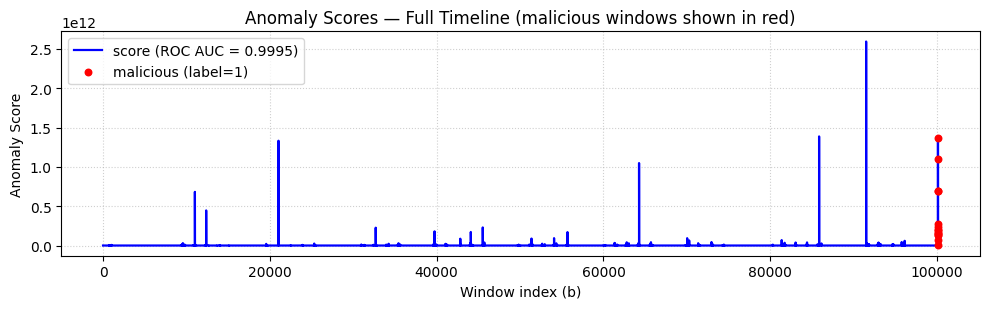

In [7]:
# full_timeline_from_scores_txt_auc.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# ===== Config =====
PATH = "anomrank_user12_combined_or_anomaly.txt"   
HAS_HEADER = False                    
SCORE_COL_NAME = "score"
LABEL_COL_NAME = "label"
X_LABEL = "Window index (b)"         

# ===== Load (robust to spaces/tabs; no header expected) =====
if HAS_HEADER:
    df = pd.read_csv(PATH, sep=r"\s+")
    # make sure columns exist
    if not {SCORE_COL_NAME, LABEL_COL_NAME}.issubset(df.columns):
        raise ValueError(f"Expected columns '{SCORE_COL_NAME}' and '{LABEL_COL_NAME}' in {PATH}")
    df = df[[SCORE_COL_NAME, LABEL_COL_NAME]].copy()
else:
    df = pd.read_csv(PATH, sep=r"\s+", header=None, names=[SCORE_COL_NAME, LABEL_COL_NAME])

# Coerce numerics & drop bad rows
df[SCORE_COL_NAME] = pd.to_numeric(df[SCORE_COL_NAME], errors="coerce")
df[LABEL_COL_NAME] = pd.to_numeric(df[LABEL_COL_NAME], errors="coerce").astype("Int64")
df = df.dropna(subset=[SCORE_COL_NAME, LABEL_COL_NAME]).reset_index(drop=True)

# Build arrays
y_score = df[SCORE_COL_NAME].to_numpy()
y_true  = df[LABEL_COL_NAME].astype(int).to_numpy()
x = np.arange(len(df))  # window index

# ROC AUC (handle degenerate cases gracefully)
try:
    auc_value = roc_auc_score(y_true, y_score)
    auc_text = f"(ROC AUC = {auc_value:.4f})"
except ValueError:
    auc_value = np.nan
    auc_text = "(ROC AUC unavailable)"

# ===== Plot =====
plt.figure(figsize=(10, 3.2))
plt.plot(x, y_score, linewidth=1.6, color="blue", label=f"score {auc_text}")

# Red dots where label == 1
mal_idx = np.where(y_true == 1)[0]
if mal_idx.size > 0:
    plt.scatter(mal_idx, y_score[mal_idx], s=22, color="red", marker="o",
                label="malicious (label=1)", zorder=5)

plt.xlabel(X_LABEL)
plt.ylabel("Anomaly Score")
plt.title("Anomaly Scores — Full Timeline (malicious windows shown in red)")
plt.grid(True, linestyle=":", alpha=0.6)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()


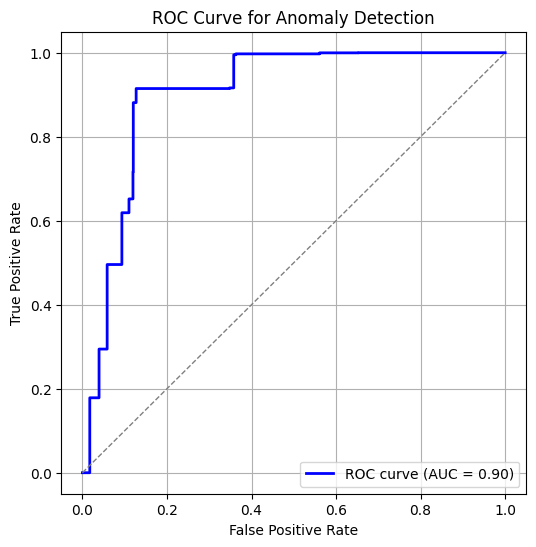

ROC-AUC Score: 0.9024976902197495


In [50]:
df = pd.read_csv("anomrank_user12_combined_or_edge_anomaly.csv")
df["atk_binary"] = (df["atk"] > 0).astype(int)
y_true = df["atk_binary"]
y_score = df["score"]
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Anomaly Detection')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
print("ROC-AUC Score:", roc_auc_score(y_true, y_score))

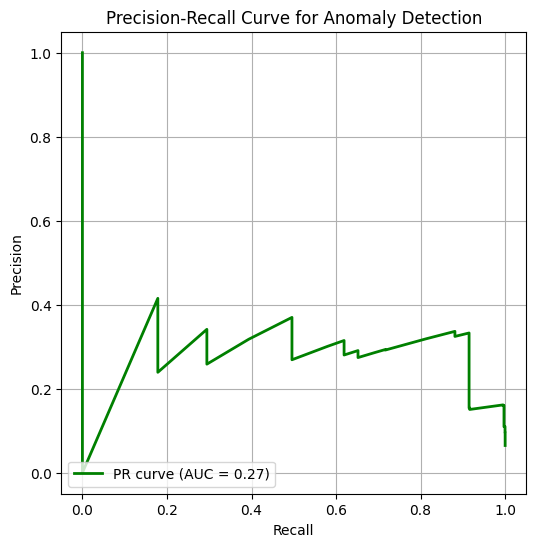

PR-AUC Score (trapz-based): 0.274182
Average Precision (sklearn): 0.327277


In [51]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score


prec, rec, _ = precision_recall_curve(y_true, y_score)

# PR-AUC 
pr_auc = auc(rec, prec)
avg_prec = average_precision_score(y_true, y_score)


plt.figure(figsize=(6,6))
plt.plot(rec, prec, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Anomaly Detection')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


print(f"PR-AUC Score (trapz-based): {pr_auc:.6f}")
print(f"Average Precision (sklearn): {avg_prec:.6f}")


In [52]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score


print("score stats:", df["score"].min(), df["score"].max())
print("unique scores:", df["score"].nunique(), " | positives:", y_true.sum(), " | negatives:", len(y_true)-y_true.sum())
print("proportion with score > 0:", (df["score"] > 0).mean())


youden = tpr - fpr
best_idx_j = np.argmax(youden)
best_thr_j  = thresholds[best_idx_j]
print(f"[Youden J] best threshold={best_thr_j:.6g}, TPR={tpr[best_idx_j]:.3f}, FPR={fpr[best_idx_j]:.3f}")


dist = (fpr**2 + (1 - tpr)**2)
best_idx_tl = np.argmin(dist)
best_thr_tl = thresholds[best_idx_tl]
print(f"[Top-Left] best threshold={best_thr_tl:.6g}, TPR={tpr[best_idx_tl]:.3f}, FPR={fpr[best_idx_tl]:.3f}")

# F1-optimal threshold via PR curve
prec, rec, thr_pr = precision_recall_curve(y_true, y_score)
# precision_recall_curve returns thresholds aligned with thr_pr; last point has no threshold
f1s = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-12)
best_idx_f1 = np.argmax(f1s)
best_thr_f1 = thr_pr[best_idx_f1]
print(f"[Max F1]   best threshold={best_thr_f1:.6g}, Precision={prec[best_idx_f1]:.3f}, Recall={rec[best_idx_f1]:.3f}, F1={f1s[best_idx_f1]:.3f}")

# manual cutoff
manual_thr = 0.5
# Compute metrics 
y_pred_manual = (y_score > manual_thr).astype(int)
from sklearn.metrics import confusion_matrix, classification_report
tn, fp, fn, tp = confusion_matrix(y_true, y_pred_manual).ravel()
tpr_manual = tp / (tp + fn) if (tp + fn) else 0.0
fpr_manual = fp / (fp + tn) if (fp + tn) else 0.0
print(f"[Manual score>0] TPR={tpr_manual:.3f}, FPR={fpr_manual:.3f}")
print(classification_report(y_true, y_pred_manual, digits=3))


score stats: 0.0 2594538049778.0405
unique scores: 1442  | positives: 13845  | negatives: 199811
proportion with score > 0: 0.6772428576777624
[Youden J] best threshold=6.68479e+10, TPR=0.915, FPR=0.127
[Top-Left] best threshold=6.68479e+10, TPR=0.915, FPR=0.127
[Max F1]   best threshold=6.68479e+10, Precision=0.333, Recall=0.915, F1=0.488
[Manual score>0] TPR=1.000, FPR=0.655
              precision    recall  f1-score   support

           0      1.000     0.345     0.513    199811
           1      0.096     1.000     0.175     13845

    accuracy                          0.388    213656
   macro avg      0.548     0.673     0.344    213656
weighted avg      0.941     0.388     0.491    213656



In [53]:
# ===== Snapshots: contiguous runs of the same anomaly score =====
import numpy as np
import pandas as pd

def compute_snapshots(times: np.ndarray,
                      values: np.ndarray,
                      eps: float | None = None,
                      round_decimals: int | None = None) -> pd.DataFrame:
    v = values.copy()

    if round_decimals is not None:
        v = np.round(v, round_decimals)

    def same(a, b):
        if eps is None:
            return a == b
        return np.abs(a - b) <= eps

    snaps = []
    start_idx = 0
    for i in range(1, len(v)):
        if not same(v[i], v[i - 1]):
            snaps.append({
                "start_time": times[start_idx],
                "end_time": times[i - 1],
                "length": i - start_idx,
                "score": v[start_idx]
            })
            start_idx = i
    # close last run
    snaps.append({
        "start_time": times[start_idx],
        "end_time": times[len(v) - 1],
        "length": len(v) - start_idx,
        "score": v[start_idx]
    })
    return pd.DataFrame(snaps)

# === Choose one score column to analyze (or loop over SCORE_COLS)
score_col = SCORE_COLS[0]

# If your scores are raw floats, rounding usually produces cleaner grouping.
# Adjust round_decimals/eps to taste: e.g., round_decimals=6 or eps=1e-9
snap_df = compute_snapshots(
    times=times,
    values=g[score_col].to_numpy(),
    round_decimals=6,   # set None if you prefer exact equality
    eps=None            # or use eps=1e-12 without rounding
)

print(f"[{score_col}] Total snapshots (contiguous runs of same score): {len(snap_df)}")
print(snap_df.head(10))  # preview

atk_times_set = set(inject_times.tolist())
def overlaps_attack(row):

    return any((t in atk_times_set) for t in times[(times >= row.start_time) & (times <= row.end_time)])

snap_df["overlaps_attack"] = snap_df.apply(overlaps_attack, axis=1)
mal_snap_df = snap_df[snap_df["overlaps_attack"]].copy()

print(f"[{score_col}] Snapshots overlapping attacks: {len(mal_snap_df)}")
# Optional summaries:
print("Top snapshots by length:")
print(snap_df.sort_values("length", ascending=False).head(10)[["start_time","end_time","length","score"]])


[score] Total snapshots (contiguous runs of same score): 1903
   start_time  end_time  length         score
0           1        20       3  0.000000e+00
1       58317     58317       1  5.768301e+09
2       58338     58349       8  4.620871e+09
3       58403     58403       1  6.418891e+05
4       58470     58471       2  1.591068e+04
5       58997     58997       1  1.006534e+04
6       59050     59098       5  4.545839e+09
7       59135     59138       4  1.318909e+08
8       59165     59207       2  1.184918e+06
9       59221     59226       4  2.707319e+09
[score] Snapshots overlapping attacks: 18
Top snapshots by length:
      start_time  end_time  length  score
1674     5168102   5169535     391    0.0
747      2134949   2138399     171    0.0
1868     5772066   5773715     141    0.0
1731     5517235   5519998     127    0.0
1878     5782626   5783336     106    0.0
552      1457235   1533120      92    0.0
1564     4486276   4815196      88    0.0
1439     4208319   4215845   

Darpa Dataset, Darpa Dataset is large..Therefore when loaded onto excel, some data might get lost

In [54]:

df = pd.read_csv("darpa_edge_anomaly.csv")
print("score stats:", df["score"].min(), df["score"].max())

score stats: 0.0 207027406.797019


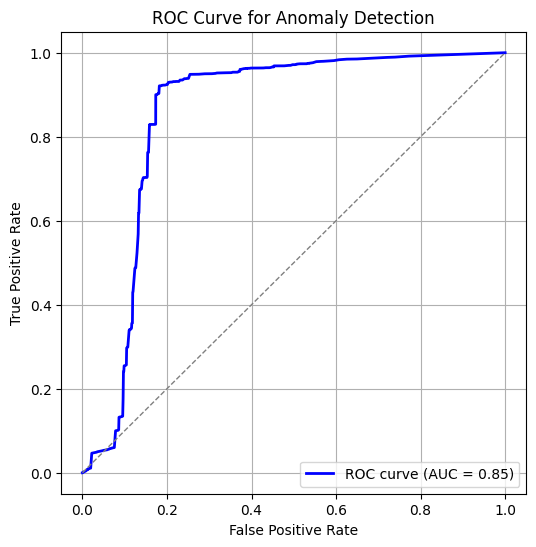

ROC-AUC Score: 0.8547489131751983


In [55]:
df = pd.read_csv("darpa_edge_anomaly.csv")
df["atk_binary"] = (df["atk"] > 0).astype(int)
y_true = df["atk_binary"]
y_score = df["score"]
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Anomaly Detection')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
print("ROC-AUC Score:", roc_auc_score(y_true, y_score))

In [56]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score


youden = tpr - fpr
best_idx_j = np.argmax(youden)
best_thr_j  = thresholds[best_idx_j]
print(f"[Youden J] best threshold={best_thr_j:.6g}, TPR={tpr[best_idx_j]:.3f}, FPR={fpr[best_idx_j]:.3f}")


dist = (fpr**2 + (1 - tpr)**2)
best_idx_tl = np.argmin(dist)
best_thr_tl = thresholds[best_idx_tl]
print(f"[Top-Left] best threshold={best_thr_tl:.6g}, TPR={tpr[best_idx_tl]:.3f}, FPR={fpr[best_idx_tl]:.3f}")

# F1-optimal threshold via PR curve
prec, rec, thr_pr = precision_recall_curve(y_true, y_score)
# precision_recall_curve returns thresholds aligned with thr_pr; last point has no threshold
f1s = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-12)
best_idx_f1 = np.argmax(f1s)
best_thr_f1 = thr_pr[best_idx_f1]
print(f"[Max F1]   best threshold={best_thr_f1:.6g}, Precision={prec[best_idx_f1]:.3f}, Recall={rec[best_idx_f1]:.3f}, F1={f1s[best_idx_f1]:.3f}")

# manual cutoff
manual_thr = 0.5
# Compute metrics 
y_pred_manual = (y_score > manual_thr).astype(int)
from sklearn.metrics import confusion_matrix, classification_report
tn, fp, fn, tp = confusion_matrix(y_true, y_pred_manual).ravel()
tpr_manual = tp / (tp + fn) if (tp + fn) else 0.0
fpr_manual = fp / (fp + tn) if (fp + tn) else 0.0
print(f"[Manual score>0] TPR={tpr_manual:.3f}, FPR={fpr_manual:.3f}")
print(classification_report(y_true, y_pred_manual, digits=3))


[Youden J] best threshold=0.027117, TPR=0.921, FPR=0.182
[Top-Left] best threshold=0.027117, TPR=0.921, FPR=0.182
[Max F1]   best threshold=0.027117, Precision=0.884, Recall=0.921, F1=0.902
[Manual score>0] TPR=0.703, FPR=0.146
              precision    recall  f1-score   support

           0      0.656     0.854     0.742   1817135
           1      0.879     0.703     0.781   2737209

    accuracy                          0.763   4554344
   macro avg      0.768     0.779     0.762   4554344
weighted avg      0.790     0.763     0.766   4554344



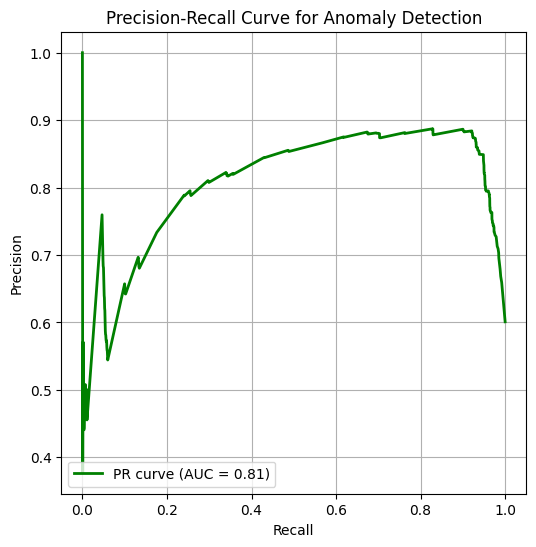

PR-AUC Score (trapz-based): 0.805610
Average Precision (sklearn): 0.819930


In [57]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score


prec, rec, _ = precision_recall_curve(y_true, y_score)

# PR-AUC 
pr_auc = auc(rec, prec)
avg_prec = average_precision_score(y_true, y_score)


plt.figure(figsize=(6,6))
plt.plot(rec, prec, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Anomaly Detection')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


print(f"PR-AUC Score (trapz-based): {pr_auc:.6f}")
print(f"Average Precision (sklearn): {avg_prec:.6f}")
